This is Dota 2 Kaggle Competition. This is Binary Classification Problem. The data is structured (tabular, csv data)
In this competition I will try to predict the winner of the game based on the statistics of the first several minutes of the game

Data Loading: I begin by loading the data, which is in CSV format, containing various game features such as player stats, hero selections, and game events.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('train_data_dota.csv')

In [4]:
test_features = pd.read_csv('test_data_dota.csv')

In [5]:
df

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_win,ID
0,871,22,0,4,2,110,2,3,11,3,...,0,10,1,0.875000,0,0,6,3,True,a363534a6344f1b0be1d7ba2c4047d9a
1,2549,22,0,17,0,114,16,2,12,24,...,1,10,0,0.535714,1,0,0,0,True,a0ba4ef0965f56d2eba69c2b9ef33353
2,1841,22,0,8,1,100,2,11,12,2,...,0,13,0,0.727273,0,0,0,0,True,18873e56c2142af326b4e08ca41df63a
3,2211,22,7,11,3,32,14,3,11,21,...,0,1,0,0.347826,0,0,0,0,True,c143931a6a8b3fb55a8ef6b9f30c6933
4,458,22,7,1,0,68,3,0,0,15,...,0,6,0,0.000000,0,0,1,1,True,5a324d8b37522e9f9684493465720023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29670,1664,3,0,8,0,17,1,6,1,8,...,0,4,0,0.363636,1,0,0,0,False,db7050396622d08c6e8a5d6aeedf5f44
29671,2898,22,7,26,108,89,4,5,17,5,...,0,7,0,0.476190,0,0,0,0,True,b1259dbd78c0e36cba45c2f567c9d3de
29672,1246,23,0,6,10,51,9,7,15,16,...,0,3,0,0.433333,0,0,0,0,True,9bae67d14d950856a9693b7efd9bce3f
29673,2620,22,7,15,10,114,9,8,5,10,...,0,11,0,0.780488,1,0,0,0,False,de2e339479cf8e5697aff693d190e411


Feature Engineering:

I one-hot encode hero IDs, which transforms hero selections into numerical columns, making them understandable for the machine learning model.
I calculate team performance metrics like experience points (XP), gold collected, and the number of towers or runes each team acquired.
I create difference metrics between the two teams (Radiant and Dire) to highlight which team is outperforming the other in various aspects of the game.

In [6]:
import pandas as pd

def one_hot_encode_hero_ids(df, radiant_columns, dire_columns, hero_id_range):
    encoded_df = pd.DataFrame(index=df.index)
    for hero_id in hero_id_range:
        encoded_df[f'hero_id_{hero_id}'] = (
            df[radiant_columns].isin([hero_id]).any(axis=1).astype(int) +
            2 * df[dire_columns].isin([hero_id]).any(axis=1).astype(int)
        )
    df = df.join(encoded_df)
    df.drop(radiant_columns + dire_columns, axis=1, inplace=True)
    return df

def process_team_metrics(df, teams, metrics):
    for metric in metrics:
        for team in teams:
            cols_to_sum = [f'{team}{i}_{metric}' for i in range(1, 6)]
            if all(col in df.columns for col in cols_to_sum):
                df[f'{team}_sum_{metric}'] = df[cols_to_sum].sum(axis=1)
                df.drop(cols_to_sum, axis=1, inplace=True)
    return df

def calculate_metric_differences(df, metrics):
    for metric in metrics:
        df[f'{metric}_difference'] = df[f'r_sum_{metric}'] - df[f'd_sum_{metric}']

    df['r_xp_gold_ratio'] = (df['r_sum_xp'] * df['r_sum_gold'])
    df['d_xp_gold_ratio'] = (df['d_sum_xp'] * df['d_sum_gold'])

    for metric in metrics:
        df.drop([f'r_sum_{metric}', f'd_sum_{metric}'], axis=1, inplace=True)

    return df

radiant_columns = [f'r{i}_hero_id' for i in range(1, 6)]
dire_columns = [f'd{i}_hero_id' for i in range(1, 6)]
hero_id_range = range(1, 121)
metrics = ['xp', 'gold', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
           'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed']
teams = ['r', 'd']

import warnings
warnings.filterwarnings('ignore')

# Apply to training data
df = one_hot_encode_hero_ids(df, radiant_columns, dire_columns, hero_id_range)
df = process_team_metrics(df, teams, metrics)
df = calculate_metric_differences(df, metrics)
print(df.head())

# Apply to the test data
test_features = one_hot_encode_hero_ids(test_features, radiant_columns, dire_columns, hero_id_range)
test_features = process_team_metrics(test_features, teams, metrics)
test_features = calculate_metric_differences(test_features, metrics)
print(test_features.head())



   game_time  game_mode  lobby_type  objectives_len  chat_len  r1_kills  \
0        871         22           0               4         2         2   
1       2549         22           0              17         0        16   
2       1841         22           0               8         1         2   
3       2211         22           7              11         3        14   
4        458         22           7               1         0         3   

   r1_deaths  r1_assists  r1_denies  r1_lh  ...  gold_difference  \
0          3          11          3      4  ...             8385   
1          2          12         24    361  ...            10986   
2         11          12          2     46  ...            -1676   
3          3          11         21    139  ...            12145   
4          0           0         15     26  ...              738   

   creeps_stacked_difference  camps_stacked_difference  \
0                         -8                        -4   
1                       

Model Training:

I split the data into training and validation sets. This allows me to train the model on one part of the data and evaluate its performance on another.
I standardize the features, ensuring all variables are on the same scale.
I apply a Logistic Regression model and an XGBoost model to predict the probability of Radiant winning.

In [7]:
X_train, X_val = train_test_split(df, test_size=0.2)

In [8]:
y_train = X_train['radiant_win']
X_train = X_train.drop(['radiant_win', 'ID'], axis=1)

y_val = X_val['radiant_win']
X_val = X_val.drop(['radiant_win', 'ID'], axis=1)


X_test = test_features.drop('ID', axis=1)

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Model Evaluation: I evaluate model performance using ROC AUC (Area Under the Curve), which measures how well the model can distinguish between wins and losses. A higher score indicates better performance.

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

model = LogisticRegressionCV(
    cv=3,                       #number of folds to 3
    random_state=677,           # Set random seed for reproducibility
    scoring='roc_auc',          # ROC AUC scoring
    penalty='l2',               # L2 regularization
    max_iter=500,               # Number of iterations
    solver='liblinear',         # Fast solver for smaller datasets
)

model.fit(X_train, y_train)
y_val_pred = model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_val_pred)
print("Validation ROC AUC:", roc_auc)

Validation ROC AUC: 0.8197985696342291


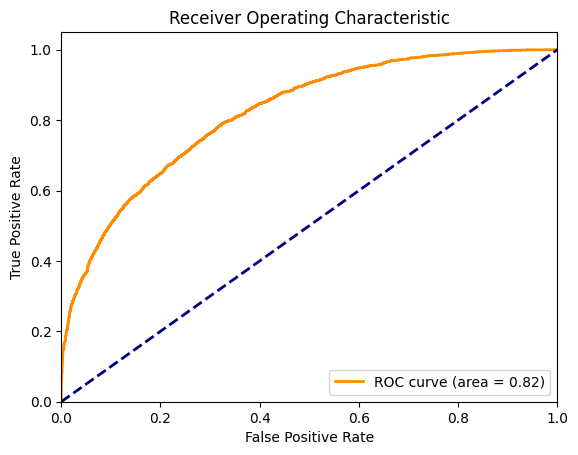

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Calculate ROC curve data points
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)

# Create a plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()




In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# Initialize the XGBClassifier
xgb_model = XGBClassifier(n_estimators=250, learning_rate=0.05, max_depth=6, subsample=0.9, colsample_bytree=0.9)

# Fit the model
xgb_model.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = xgb_model.predict_proba(X_val)[:, 1]

# Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_pred_proba)
print("Validation ROC AUC:", roc_auc)


Validation ROC AUC: 0.8327259176800434


Ensemble Modeling: To compare results, I combine the Logistic Regression and XGBoost models into a Voting Classifier and evaluate the ROC AUC score again.

In [13]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# models
logistic_model = LogisticRegressionCV(cv=5, random_state=677, Cs=[0.1, 1, 10, 100], scoring='roc_auc', penalty='l2', max_iter=1000, solver='liblinear', class_weight='balanced')
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=4, subsample=0.9, colsample_bytree=0.9)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', logistic_model),
        ('xgb', xgb_model)
    ],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

y_val_pred_voting = voting_clf.predict_proba(X_val)[:, 1]

roc_auc_voting = roc_auc_score(y_val, y_val_pred_voting)
print("Validation ROC AUC with Voting:", roc_auc_voting)


Validation ROC AUC with Voting: 0.8262114914208533


In [16]:
y_test_pred = xgb_model.predict_proba(X_test)[:, 1]

In [17]:
y_test_pred

array([0.18297413, 0.49601114, 0.57032627, ..., 0.10415959, 0.854512  ,
       0.8545368 ], dtype=float32)

Submission: Finally, I prepare the test results, predicting which team is more likely to win, and save the results to a file for submission.

In [18]:
import numpy as np
submission_array = np.vstack([test_features['ID'].values, y_test_pred]).T
submission_df = pd.DataFrame(submission_array, columns=['ID', 'radiant_win']).reset_index(drop=True)
submission_df.to_csv('simple_baseline.csv', index=None)